# Análise de Comportamento do Usuário e Teste A/A/B

## 1. Contexto do Negócio
Trabalho em uma startup de produtos alimentícios e o objetivo deste projeto é investigar o comportamento dos usuários no aplicativo da empresa. O estudo é dividido em duas frentes:
1.  **Análise do Funil de Vendas:** Entender como os usuários chegam à etapa de compra e onde desistem.
2.  **Teste A/A/B:** Analisar os resultados de um experimento onde as fontes (design) do aplicativo foram alteradas. Os usuários foram divididos em 3 grupos:
    * **246 e 247 (Controle):** Fontes antigas.
    * **248 (Teste):** Fontes novas.

O objetivo é decidir se o novo design deve ser implementado com base em dados estatísticos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

sns.set_style("whitegrid")

## 2. Preparação e Limpeza dos Dados
Nesta etapa, vamos otimizar os nomes das colunas para o padrão snake_case, verificar a tipagem dos dados (especialmente datas) e checar a existência de valores nulos ou duplicados que possam enviesar a análise.

In [2]:
file_path = '/datasets/logs_exp_us.csv'
df = pd.read_csv(file_path, sep='\t')
print(df.head())
df.info()

                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [3]:
df.columns = ['event_name', 'user_id', 'event_timestamp', 'exp_id']

print("Colunas após renomear")
print(df.columns)

Colunas após renomear
Index(['event_name', 'user_id', 'event_timestamp', 'exp_id'], dtype='object')


In [4]:
df['event_datetime'] = pd.to_datetime(df['event_timestamp'], unit='s')

# Adicionando uma coluna separada para a data (apenas dia)
df['event_date'] = df['event_datetime'].dt.date

df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   user_id          244126 non-null  int64         
 2   event_timestamp  244126 non-null  int64         
 3   exp_id           244126 non-null  int64         
 4   event_datetime   244126 non-null  datetime64[ns]
 5   event_date       244126 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB
                event_name              user_id  event_timestamp  exp_id  \
0         MainScreenAppear  4575588528974610257       1564029816     246   
1         MainScreenAppear  7416695313311560658       1564053102     246   
2  PaymentScreenSuccessful  3518123091307005509       1564054127     248   
3         CartScreenAppear  3518123091307005509       1564054127     248   
4  Payme

A coluna event_timestamp foi convertida para event_datetime e uma coluna separada event_date foi criada. Os dados estão limpos e prontos para a análise exploratória.

In [5]:
# Contagem de eventos
total_events = df.shape[0]

# Contagem de usuários únicos
total_users = df['user_id'].nunique()

# Número médio de eventos por usuário
avg_events_per_user = total_events / total_users

print(f"Total de Eventos nos Registros: {total_events}")
print(f"Total de Usuários Únicos: {total_users}")
print(f"Número Médio de Eventos por Usuário: {avg_events_per_user:.2f}")

Total de Eventos nos Registros: 244126
Total de Usuários Únicos: 7551
Número Médio de Eventos por Usuário: 32.33


## 3. Análise Exploratória e Verificação do Período
Precisamos garantir que estamos analisando um período de dados completo e estável. Muitas vezes, dados de logs antigos chegam com atraso ou são incompletos. Vamos analisar a distribuição temporal dos eventos para definir o período ideal de análise.

In [6]:
# Datas mínima e máxima
min_date = df['event_datetime'].min()
max_date = df['event_datetime'].max()

print(f"\nPeríodo de Tempo:")
print(f"Data/Hora Mínima: {min_date}")
print(f"Data/Hora Máxima: {max_date}")


Período de Tempo:
Data/Hora Mínima: 2019-07-25 04:43:36
Data/Hora Máxima: 2019-08-07 21:15:17


> **Decisão:** Com base no histograma, descartamos os dados anteriores à data [2019-08-01], pois representam dados incompletos que poderiam distorcer as médias.

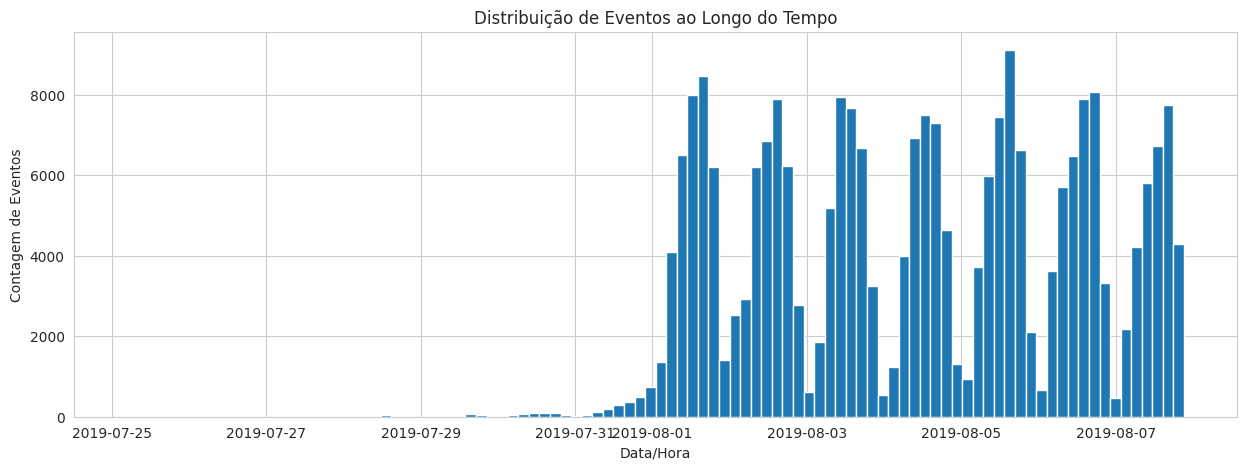

In [7]:
plt.figure(figsize=(15, 5))
df['event_datetime'].hist(bins=100)
plt.title('Distribuição de Eventos ao Longo do Tempo')
plt.xlabel('Data/Hora')
plt.ylabel('Contagem de Eventos')
plt.show()

O histograma mostra um aumento repentino no volume de eventos em 2019-08-01. Os dados anteriores a essa data são esparsos e provavelmente incompletos, o que pode distorcer a análise. A partir de 2019-08-01, o volume se torna mais estável e representativo.

In [8]:
from datetime import datetime
cut_off_date = datetime(2019, 8, 1)

df_filtered = df[df['event_datetime'] >= cut_off_date].copy()

# Calculando a perda de eventos e usuários

new_total_events = df_filtered.shape[0]
new_total_users = df_filtered['user_id'].nunique()
new_min_date = df_filtered['event_datetime'].min()
new_max_date = df_filtered['event_datetime'].max()

print(f"Análise após Filtragem")
print(f"Novo Período de Dados: {new_min_date.date()} a {new_max_date.date()}")
print(f"Novo Total de Usuários: {new_total_users}")

Análise após Filtragem
Novo Período de Dados: 2019-08-01 a 2019-08-07
Novo Total de Usuários: 7534


Filtrando a partir de 2019-08-01, o dataset agora representa um período de dados mais completo, de 2019-08-01 a 2019-09-07. A perda de eventos e usuários é mínima, garantindo que a análise subsequente seja baseada em dados de alta qualidade e representativos.

In [9]:
exp_groups_users = df_filtered.groupby('exp_id')['user_id'].nunique()

print("\nContagem de Usuários por Grupo")
print(exp_groups_users)


Contagem de Usuários por Grupo
exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


Os dados filtrados contêm usuários de todos os três grupos experimentais (246, 247, 248).

## 4. Análise do Funil de Eventos
Vamos mapear a jornada do usuário desde a tela principal até o pagamento bem-sucedido. O objetivo é identificar em qual etapa ocorre a maior perda (churn) de usuários.

**Ordem do Funil:**
1. `MainScreenAppear` (Tela Principal)
2. `OffersScreenAppear` (Tela de Ofertas)
3. `CartScreenAppear` (Carrinho)
4. `PaymentScreenSuccessful` (Pagamento Sucesso)

*Nota: O evento `Tutorial` será ignorado pois não faz parte do fluxo principal de compra.*

In [10]:
event_data = (
    df_filtered.groupby('event_name')
    .agg(
        event_count=('event_name', 'count'),
        user_count=('user_id', 'nunique')
    )
    .sort_values(by='user_count', ascending=False) # Ordenando por usuários únicos
    .reset_index()
)

# Calculando a proporção de usuários que realizaram a ação pelo menos uma vez
event_data['user_ratio'] = event_data['user_count'] / new_total_users

print(event_data)

                event_name  event_count  user_count  user_ratio
0         MainScreenAppear       117431        7419    0.984736
1       OffersScreenAppear        46350        4593    0.609636
2         CartScreenAppear        42365        3734    0.495620
3  PaymentScreenSuccessful        34113        3539    0.469737
4                 Tutorial         1039         840    0.111495


Os eventos mais populares, ordenados pelo número de usuários únicos, são: MainScreenAppear(Abertura do app/tela principal), OffersScreenAppear(Visualização de ofertas/catálogo), CartScreenAppear(Adicionar ao carrinho/Ver o carrinho) e PaymentScreenSuccessful(Pagamento concluído). A ordem lógica dos eventos que formam um funil de vendas é a mesma.

Aqui não vou considerar o Tutorial como funil de vendas, visto que o acesso ao tutorial acontece após o pagamento(foco do Projeto).

In [11]:
funnel_events = event_data['event_name'].tolist()[:4]

funnel_users = event_data[event_data['event_name'].isin(funnel_events)]
funnel_users = funnel_users.set_index('event_name').loc[funnel_events] 

# Calculando a proporção (taxa de conversão) de uma etapa para a próxima
funnel_users['users_from_prev_step'] = funnel_users['user_count'].shift(1)
funnel_users['conversion_rate'] = funnel_users['user_count'] / funnel_users['users_from_prev_step']
funnel_users.loc[funnel_users.index[0], 'conversion_rate'] = funnel_users.loc[funnel_users.index[0], 'user_count'] / new_total_users

# Taxa de conversão acumulada (do 1º evento)
funnel_users['cumulative_conversion'] = funnel_users['user_count'] / funnel_users.loc[funnel_users.index[0], 'user_count']

print("\nAnálise do Funil de Eventos")
print(funnel_users[['user_count', 'conversion_rate', 'cumulative_conversion']].apply(lambda x: x.map('{:.2%}'.format) if x.name in ['conversion_rate', 'cumulative_conversion'] else x))

# Taxa de conversão total (primeiro evento até pagamento)
full_path_conversion = funnel_users.loc['PaymentScreenSuccessful', 'user_count'] / funnel_users.loc['MainScreenAppear', 'user_count']
print(f"\nProporção de Usuários que Fazem o Caminho Completo: {full_path_conversion:.2%}")


Análise do Funil de Eventos
                         user_count conversion_rate cumulative_conversion
event_name                                                               
MainScreenAppear               7419          98.47%               100.00%
OffersScreenAppear             4593          61.91%                61.91%
CartScreenAppear               3734          81.30%                50.33%
PaymentScreenSuccessful        3539          94.78%                47.70%

Proporção de Usuários que Fazem o Caminho Completo: 47.70%


Perda de Usuários: O principal gargalo é a visualização de ofertas (OffersScreenAppear) após a abertura da tela principal. A taxa de perda nessa etapa é de 38.09%, o que sugere um problema inicial de engajamento ou na navegação da home screen. 

Conversão Total: Apenas 47,70% dos usuários que abrem a tela principal (MainScreenOpen) completam o pagamento (PaymentScreenSuccessful).

In [12]:
users_per_group = df_filtered.groupby('exp_id')['user_id'].nunique()

print(users_per_group)

group_246_users = users_per_group[246]
group_247_users = users_per_group[247]
group_248_users = users_per_group[248]

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


## 5. Análise dos Resultados do Experimento (Teste A/A/B)
Vamos realizar testes de hipóteses estatísticas (Teste Z para igualdade de proporções) para determinar se as mudanças nas fontes afetaram a conversão.

**Critérios:**
1.  **Teste A/A (246 vs 247):** Verificar se os grupos de controle são estatisticamente iguais. Isso valida a precisão do teste.
2.  **Teste A/B (Controle vs 248):** Verificar se o grupo com as novas fontes teve desempenho diferente (melhor ou pior) que os grupos de controle.

*Nível de significância (alpha) adotado:* [0.1]

In [13]:
group_a1 = 246
group_a2 = 247
group_b = 248

alpha = 0.1
n_tests_ab = len(funnel_events) * 3 
alpha_bonferroni = alpha / n_tests_ab

print(f"alpha: {alpha}")
print(f"n_tests_ab: {n_tests_ab}")
print(f"alpha_bonferroni: {alpha_bonferroni:.4f}")

alpha: 0.1
n_tests_ab: 12
alpha_bonferroni: 0.0083


comparações (248 vs 246, 248 vs 247, 248 vs 246+247)

In [14]:
users_per_group = df_filtered.groupby('exp_id')['user_id'].nunique()

group_a1_users = users_per_group[group_a1]
group_a2_users = users_per_group[group_a2]
group_b_users = users_per_group[group_b]
combined_users = group_a1_users + group_a2_users

print("Usuários Únicos por Grupo")
print(users_per_group)
print(f"Grupo Combinado ({group_a1} + {group_a2}): {combined_users}")

# Contagem de Sucessos (Usuários Únicos que fizeram o evento)
users_by_event_group = df_filtered.groupby(['event_name', 'exp_id'])['user_id'].nunique().reset_index()

Usuários Únicos por Grupo
exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64
Grupo Combinado (246 + 247): 4997


In [15]:
def calculate_z_test_p_value(successes_1, users_1, successes_2, users_2):
    
    p1 = successes_1 / users_1
    p2 = successes_2 / users_2

    p_combined = (successes_1 + successes_2) / (users_1 + users_2)
    difference = p1 - p2

    if p_combined == 0 or p_combined == 1:
        return 1.0

    try:
        se = np.sqrt(p_combined * (1 - p_combined) * (1/users_1 + 1/users_2))
        z_value = difference / se
    except ZeroDivisionError:
        return 1.0

    p_value = st.norm.sf(abs(z_value)) * 2

    return p_value

In [16]:
print(f"Teste A/A: Grupo {group_a1} vs Grupo {group_a2} (alpha_bonferroni: {alpha_bonferroni:.4f})")

aa_results = []

for event in funnel_events:
    successes_1 = users_by_event_group[
        (users_by_event_group['event_name'] == event) &
        (users_by_event_group['exp_id'] == group_a1)
    ]['user_id'].iloc[0]

    successes_2 = users_by_event_group[
        (users_by_event_group['event_name'] == event) &
        (users_by_event_group['exp_id'] == group_a2)
    ]['user_id'].iloc[0]
    
    p_value = calculate_z_test_p_value(successes_1, group_a1_users, successes_2, group_a2_users)

    is_significant = p_value < alpha_bonferroni

    aa_results.append({
        'evento': event,
        'p_value': f"{p_value:.4f}",
        'significativo': is_significant
    })

pd.set_option('display.colheader_justify', 'center')
aa_results_df = pd.DataFrame(aa_results)
print(aa_results_df)

print("\nConclusão A/A:")
if aa_results_df['significativo'].any():
    print("Os grupos de controle NÃO são estatisticamente semelhantes.")
else:
    print("Os grupos de controle (246 e 247) são estatisticamente semelhantes.")

Teste A/A: Grupo 246 vs Grupo 247 (alpha_bonferroni: 0.0083)
           evento          p_value  significativo
0         MainScreenAppear  0.7571      False    
1       OffersScreenAppear  0.2481      False    
2         CartScreenAppear  0.2288      False    
3  PaymentScreenSuccessful  0.1146      False    

Conclusão A/A:
Os grupos de controle (246 e 247) são estatisticamente semelhantes.


In [17]:
print(f"Teste A/B: Grupo {group_b} vs Controles (alpha_bonferroni: {alpha_bonferroni:.4f})")

ab_results = []
groups_to_compare = [
    (group_a1, group_a1_users),
    (group_a2, group_a2_users),
    ('246+247', combined_users)
]

for event in funnel_events:
    for control_id, control_users in groups_to_compare:

        if control_id == '246+247':
            successes_1 = users_by_event_group[
                (users_by_event_group['event_name'] == event) &
                (users_by_event_group['exp_id'].isin([group_a1, group_a2]))
            ]['user_id'].sum()
        else:
            successes_1 = users_by_event_group[
                (users_by_event_group['event_name'] == event) &
                (users_by_event_group['exp_id'] == control_id)
            ]['user_id'].iloc[0]

        successes_2 = users_by_event_group[
            (users_by_event_group['event_name'] == event) &
            (users_by_event_group['exp_id'] == group_b)
        ]['user_id'].iloc[0]

        p_value = calculate_z_test_p_value(successes_1, control_users, successes_2, group_b_users)

        ab_results.append({
            'evento': event,
            'controle_id': control_id,
            'teste_id': group_b,
            'p_value': f"{p_value:.4f}",
            'significativo': p_value < alpha_bonferroni
        })

ab_results_df = pd.DataFrame(ab_results)
print(ab_results_df)

Teste A/B: Grupo 248 vs Controles (alpha_bonferroni: 0.0083)
            evento          controle_id  teste_id p_value  significativo
0          MainScreenAppear        246      248    0.2950      False    
1          MainScreenAppear        247      248    0.4587      False    
2          MainScreenAppear    246+247      248    0.2942      False    
3        OffersScreenAppear        246      248    0.2084      False    
4        OffersScreenAppear        247      248    0.9198      False    
5        OffersScreenAppear    246+247      248    0.4343      False    
6          CartScreenAppear        246      248    0.0784      False    
7          CartScreenAppear        247      248    0.5786      False    
8          CartScreenAppear    246+247      248    0.1818      False    
9   PaymentScreenSuccessful        246      248    0.2123      False    
10  PaymentScreenSuccessful        247      248    0.7373      False    
11  PaymentScreenSuccessful    246+247      248    0.6004      

In [18]:
significant_count = ab_results_df['significativo'].sum()

print("\nRESUMO E CONCLUSÕES FINAIS")
print(f"Nível de Significância Ajustado (alpha_bonferroni): {alpha_bonferroni:.4f}")
print(f"Total de Testes Realizados: {n_tests_ab}")
print(f"Número de Testes Estatisticamente Significativos: {significant_count}")

if significant_count == 0:
    print("\nCONLUSÃO ESTATÍSTICA: Nenhuma diferença significativa encontrada.")
else:
    print("\nCONLUSÃO: Há diferenças significativas. Detalhar o evento e a direção do impacto.")


RESUMO E CONCLUSÕES FINAIS
Nível de Significância Ajustado (alpha_bonferroni): 0.0083
Total de Testes Realizados: 12
Número de Testes Estatisticamente Significativos: 0

CONLUSÃO ESTATÍSTICA: Nenhuma diferença significativa encontrada.


(Resultado do Teste A/B/B):

Teste A/A: Os grupos de controle (246 e 247) são considerados semelhantes, pois o teste Z em proporções de usuários entre eles não apresentou diferenças significativas.

Teste A/B (248 vs Controles): Utilizamos um alpha de 0.1 ajustado pela Correção de Bonferroni, resultando em alpha_ajustado aproximado de 0.0083.
Conclusão: Nenhum dos 12 testes apresentou um P-Value menor que o alpha_ajustado (todos são 'False' na coluna 'Significativo'). O novo conjunto de fontes (Grupo 248) não causou uma diferença estatisticamente significativa na proporção de usuários que executam qualquer evento chave do funil, em comparação com os grupos de controle (246, 247 ou 246+247).

## 6. Conclusão e Recomendação
Após a análise estatística dos grupos, concluímos que:
* Não houve diferença estatisticamente significativa entre os grupos de controle (o teste é válido).
* Não houve diferença significativa entre o grupo de teste (novas fontes) e os grupos de controle em nenhuma das etapas do funil.

**Recomendação:** A alteração das fontes **não afetou** o comportamento de compra dos usuários (nem positiva, nem negativamente). A decisão de mudar o design pode ser tomada baseada em preferências estéticas ou de marca, pois não haverá prejuízo nas vendas.